In [9]:
#!pip install torchtext
#!pip install pandas

In [10]:
import torch
import torch.nn as nn
import torchtext.data as ttd
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [13]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [14]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [15]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [16]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
# rename columns to something better
df.columns = ['labels', 'data']

In [18]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [20]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [21]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [22]:
# get sequence lengths
train_lengths = [len(x) for x in sequences_train]
test_lengths = [len(x) for x in sequences_test]

In [23]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 7211 unique tokens.


In [24]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (3733, 189)


In [25]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 189)


In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
data_train_t = torch.from_numpy(data_train).long()
y_train_t = torch.from_numpy(Ytrain)
data_test_t = torch.from_numpy(data_test).long()
y_test_t = torch.from_numpy(Ytest)

In [28]:
# create dataset objects
train_dataset = torch.utils.data.TensorDataset(data_train_t, y_train_t)

test_dataset = torch.utils.data.TensorDataset(data_test_t, y_test_t)

In [29]:
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=32, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=256, 
                                          shuffle=False)

In [30]:
for inputs, targets in train_loader:
  print("inputs:", inputs, "shape:", inputs.shape)
  print("targets:", targets, "shape:", targets.shape)
  break

inputs: tensor([[   0,    0,    0,  ..., 3503, 3504,  314],
        [   0,    0,    0,  ...,    2, 1581,  193],
        [   0,    0,    0,  ...,   84,   16,  109],
        ...,
        [   0,    0,    0,  ...,  849, 1202,  511],
        [   0,    0,    0,  ...,   13,  624,  108],
        [   0,    0,    0,  ...,   46,   79, 3110]]) shape: torch.Size([32, 189])
targets: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0]) shape: torch.Size([32])


In [31]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    # max pool
    out, _ = torch.max(out, 1)

    # we only want h(T) at the final time step
    out = self.fc(out)
    return out

In [32]:
model = RNN(V+1, 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(7212, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

In [33]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())


In [34]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      # print("inputs.shape:", inputs.shape, "targets.shape:", targets.shape)
      targets = targets.view(-1, 1).float()
      # move data to GPU
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
        
      # Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # Get train loss and test loss
    train_loss = np.mean(train_loss) # a little misleading
    
    test_loss = []
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      targets = targets.view(-1, 1).float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')
  
  return train_losses, test_losses

In [35]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, 15)

Epoch 1/15, Train Loss: 0.5405,       Test Loss: 0.4163, Duration: 0:00:01.241155
Epoch 2/15, Train Loss: 0.3708,       Test Loss: 0.3551, Duration: 0:00:01.270849
Epoch 3/15, Train Loss: 0.3053,       Test Loss: 0.2921, Duration: 0:00:01.159688
Epoch 4/15, Train Loss: 0.2311,       Test Loss: 0.2267, Duration: 0:00:01.143205
Epoch 5/15, Train Loss: 0.1621,       Test Loss: 0.1766, Duration: 0:00:01.062813
Epoch 6/15, Train Loss: 0.1126,       Test Loss: 0.1430, Duration: 0:00:00.998045
Epoch 7/15, Train Loss: 0.0813,       Test Loss: 0.1272, Duration: 0:00:01.022842
Epoch 8/15, Train Loss: 0.0634,       Test Loss: 0.1168, Duration: 0:00:01.098085
Epoch 9/15, Train Loss: 0.0512,       Test Loss: 0.1132, Duration: 0:00:01.050181
Epoch 10/15, Train Loss: 0.0439,       Test Loss: 0.1120, Duration: 0:00:01.098232
Epoch 11/15, Train Loss: 0.0368,       Test Loss: 0.1055, Duration: 0:00:01.254291
Epoch 12/15, Train Loss: 0.0323,       Test Loss: 0.1083, Duration: 0:00:01.300055
Epoch 13/15, 

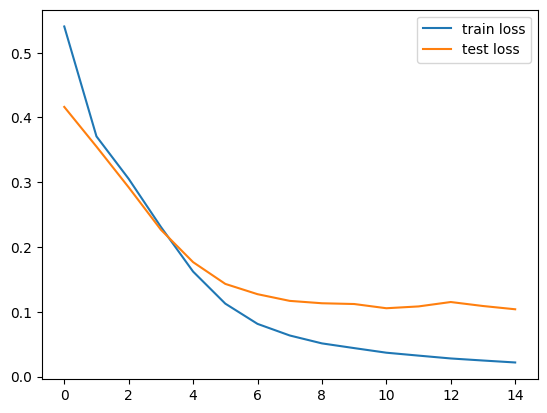

In [36]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [37]:
# Accuracy

n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
  targets = targets.view(-1, 1).float()
  inputs, targets = inputs.to(device), targets.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  predictions = (outputs > 0)
  
  # update counts
  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9968, Test acc: 0.9766


In [38]:
### Make predictions on a new test sentence ###

# pick a random sentence
# test_sent = df[df.labels == 'spam'].sample()['data'].values

# use a hard-coded sentence
test_sent = ['Not heard from U4 a while. Call 4 rude chat private line']

print("Sentence:", test_sent)
test_seq = tokenizer.texts_to_sequences(test_sent)
test_seq

Sentence: ['Not heard from U4 a while. Call 4 rude chat private line']


[[24, 814, 51, 2783, 4, 418, 16, 44, 1646, 225, 717, 272]]

In [39]:
test_padded = pad_sequences(test_seq, maxlen=T)
test_padded

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0, 

In [40]:
# correctly identified as spam
model(torch.from_numpy(test_padded).long().to(device))

tensor([[1.4399]], grad_fn=<AddmmBackward0>)